### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

#### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2020

Búsqueda y Recomendación de Textos Legales - Análisis y Curación de Datos

Mentor: Claudio Sarate

Integrantes:

* Ezequiel Juarez
* Jorge Pérez 
* Clara Quintana
* David Veisaga

## Aprendizaje No Supervisado

* El objetivo de este práctico es utilizar todo lo logrado y analizado a nivel de corpus para generar clases con distintas herramientas que permitan relacionar los documentos con mayor similitud.

### Enunciado del práctico

 ----------------------------------------------------------------------------------------------------------

* Se pide realizar Topic Modeling utilizando LDA (Latent Dirichlet Allocation) y (NMF) Non-negative Matrix Factorization sobre el corpus.

***NOTA: no confundir con LDA (Linear Discriminant Analysis)***

* Realizar el proceso utilizando Gensim-Doc2Vec

 ----------------------------------------------------------------------------------------------------------

Leemos el corpus de Infoleg

In [1]:
import sys
import os
import time
import pandas

In [2]:
# Se verfica entorno de ejecución
in_colab = "google.colab" in sys.modules

if in_colab:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/My Drive/Diplo2020 Mentoria/"
else:
    BASE_DIR = "../"

In [3]:
file = BASE_DIR + "Datos/Infoleg.cor"
df_corpus = pandas.read_csv(file, sep=" ", names=["ID", "TEXTO"], header=0)
df_corpus.head()

,ID,TEXTO
0,0,"ministerio de trabajo, empleo y seguridad soci..."
1,1,administracion federal de ingresos publicos di...
2,2,administración federal de ingresos públicos ob...
3,3,(nota infoleg: norma abrogada por art. 2° de l...
4,4,"secretaria de ciencia, tecnologia e innovacion..."


Función de normalización

In [4]:
import string
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

In [5]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def normalize_texto(texto, stop_words):
    # Tokenización
    tokens = ToktokTokenizer().tokenize(texto)

    # Paso a minúscula
    tokens = [word.lower() for word in tokens]

    # Eliminamos símbolos de puntuación
    signos_puntuacion = string.punctuation + '—'
    tokens = list(filter(lambda token: token not in signos_puntuacion, tokens))

    # Eliminar acentos y reemplazar abreviaturas
    dic_Errores = {'nro':'numero', 'nro.':'numero', 'n°':'numero', 'n.°':'numero', 'nº':'numero', 'n.º':'numero', 'art.':'articulo'}
    for i in range(len(tokens)):  
        for a, b in (("á", "a"), ("é", "e"), ("í", "i"), ("ó", "o"), ("ú", "u"),):
            tokens[i] = tokens[i].replace(a, b)       
        for key in dic_Errores:
            if tokens[i] == key:
                tokens[i] = dic_Errores[key]

    # eliminar la puntuación de cada palabra
    tokens = [re.sub('[%s]' % re.escape(signos_puntuacion), '', token) for token in tokens]
    
    # eliminar los números
    tokens = list(filter(lambda token: token.isalpha(), tokens))

    # Eliminamos stopwords
    tokens = list(filter(lambda token: token not in stop_words, tokens)) 

    # Lemmatización
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # eliminar los tokens de menos de 3 caracteres
    tokens = list(filter(lambda token: len(token) > 3, tokens))

    return ' '.join(tokens)


Agregamos una columna con el texto normalizado

In [8]:
df_corpus["TEXTO_NORM"] = df_corpus["TEXTO"].apply(lambda x: normalize_texto(x, stop_words))
df_corpus.head()

,ID,TEXTO,TEXTO_NORM
0,0,"ministerio de trabajo, empleo y seguridad soci...",ministerio trabajo empleo seguridad social sup...
1,1,administracion federal de ingresos publicos di...,administracion federal ingresos publicos direc...
2,2,administración federal de ingresos públicos ob...,administracion federal ingresos publicos oblig...
3,3,(nota infoleg: norma abrogada por art. 2° de l...,nota infoleg norma abrogada articulo resolucio...
4,4,"secretaria de ciencia, tecnologia e innovacion...",secretaria ciencia tecnologia innovacion produ...


#### Preproceso

* De acuerdo a los procesos ya realizados previamente elegir que realizar para tener una matriz de términos de los documentos, podría ser mediante Scikit-Learn realizando una vectorización TF-IDF para crear una matriz de términos de documentos (si se utiliza este proceso explorar los parámetros max_df y min_df para entender su significado.)

En el práctico anterior ampliamos el listado de stop words obteniendo el peso IDF (Frecuencia Inversa de Documentos).

En este caso utilizaremos los parámetros max_df (términos más frecuentes) y min_df (términos menos frecuentes).

Utilizaremos TfidVectorizer con los siguientes parámetros:
* use_idf: habilitar la ponderación frecuencia inversa de documentos
* ngram_range: inluiremos bi-gramas
* min_df: ignoraremos los términos que aparecen en menos del 1% de lo documentos.
* max_df: ignoraremos los términos que aparecen en más del 90 % de los documentos.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, ngram_range=(1,2), min_df=.01, max_df=.90) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df_corpus['TEXTO_NORM'])

In [11]:
print(f'Cantidad de palabras en nuestro vocabulario: {len(tfidf_vectorizer.vocabulary_)}')

Cantidad de palabras en nuestro vocabulario: 7773


Observamos los valores de TF-IDF del primer documento

In [12]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

df = pandas.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
riesgos trabajo,0.313567
trabajo,0.301579
riesgos,0.292361
superintendencia,0.234595
acciones,0.216306
salud,0.173989
seguridad trabajo,0.166319
sistema,0.139781
organismo,0.137922
subgerencia,0.128747


 ----------------------------------------------------------------------------------------------------------

#### LDA (Latent Dirichlet Allocation)

* Utilizando Scikit-Learn crear una instancia de LDA con la cantidad de componentes (clases) que consideren apropiada de acuerdo al conocimiento que ya tienen del dominio (usar random_state=42)

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

Consideraremos 10 clases

In [14]:
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)

In [15]:
begin_time = time.time()
lda_model.fit(tfidf_vectorizer_vectors)
# grabamos el tiempo de ejecución
lda_time = time.time() - begin_time

* Mostrar las 15 palabras mas comunes para cada uno de los tópicos que hayan decido que buscan.

In [16]:
for index in range(10):
    topico = lda_model.components_[index]
    print(f'\n15 Palabras más comunes del Tópico {index}')
    print([tfidf_vectorizer.get_feature_names()[index] for index in topico.argsort()[-15:]])


15 Palabras más comunes del Tópico 0
['anexo', 'registro', 'servicios', 'secretaria', 'direccion', 'acuerdo', 'decreto', 'fecha', 'trabajo', 'ministerio', 'presente', 'resolucion', 'nacional', 'numero', 'articulo']

15 Palabras más comunes del Tópico 1
['administracion federal', 'subdireccion', 'mercaderias', 'control aduanero', 'subdireccion general', 'general', 'externa numero', 'direccion general', 'aduana', 'aduanera', 'externa', 'nota externa', 'aduanero', 'general aduanas', 'aduanas']

15 Palabras más comunes del Tópico 2
['autarquica ambito', 'produccion resuelve', 'obrante planillas', 'grupo mercado', 'exministerio', 'sinapa', 'detalle obrante', 'cuenta conformidad', 'resolucion fijanse', 'hacienda ministerio', 'distribucion presupuesto', 'mineria dependiente', 'toda designacion', 'articulo prorrogase', 'compete secretaria']

15 Palabras más comunes del Tópico 3
['subsecretaria politica', 'compete secretaria', 'articulo gastos', 'gastos demande', 'partidas especificas', 'atend

* Hacer un análisis si entre las palabras mas comunes se detecta algún tópico que pudiera definirse como clase

 ----------------------------------------------------------------------------------------------------------

#### NMF (Non-negative Matrix Factorization)

* Utilizando Scikit-Learn crear una instancia de NMF con la cantidad de componentes (clases) que consideren apropiada de acuerdo al conocimiento que ya tienen del dominio (usar random_state=42)

In [17]:
from sklearn.decomposition import NMF

Consideraremos 10 clases

In [18]:
nmf_model = NMF(n_components=10,random_state=42)

In [19]:
begin_time = time.time()
nmf_model.fit(tfidf_vectorizer_vectors)
# grabamos el tiempo de ejecución
mnf_time = time.time() - begin_time

* Mostrar las 15 palabras mas comunes para cada uno de los tópicos que hayan decido que buscan.

In [20]:
for index in range(10):
    topico = nmf_model.components_[index]
    print(f'\n15 Palabras más comunes del Tópico {index}')
    print([tfidf_vectorizer.get_feature_names()[index] for index in topico.argsort()[-15:]])


15 Palabras más comunes del Tópico 0
['empleo', 'ministerio trabajo', 'empleo seguridad', 'trabajo empleo', 'remuneraciones tope', 'importe', 'promedio mensual', 'secretaria trabajo', 'indemnizatorio', 'tope indemnizatorio', 'importe promedio', 'tope', 'promedio', 'numero', 'trabajo']

15 Palabras más comunes del Tópico 1
['republica argentina', 'central', 'banco', 'central republica', 'argentina bcra', 'banco central', 'citada comunicacion', 'entidad citada', 'bcra', 'bcra enlace', 'comunicacion', 'autorizado', 'enlace', 'autorizado entidad', 'enlace autorizado']

15 Palabras más comunes del Tópico 2
['inversion publica', 'planificacion federal', 'publica servicios', 'federal inversion', 'nacion', 'inversion', 'presupuesto', 'transporte', 'servicios', 'publica', 'decreto', 'ministerio', 'articulo', 'nacional', 'numero']

15 Palabras más comunes del Tópico 3
['social', 'seguridad social', 'empleo', 'empleo seguridad', 'trabajo empleo', 'nacional relaciones', 'relaciones trabajo', 'min

* Hacer un análisis si entre las palabras mas comunes se detecta algún tópico que pudiera definirse como clase

 ----------------------------------------------------------------------------------------------------------

* Evaluar velocidad de proceso para saber cual de los dos es mas rápido y cual tiene la agrupación de tópicos mas cercana a lo que podrían ser clases válidas para la agrupación de documentos.

In [21]:
print(f'LDA demoró {lda_time:.4f} segundos')
print(f'MNF demoró {mnf_time:.4f} segundos')

LDA demoró 10.9812 segundos
MNF demoró 1.8971 segundos


MNF fue mucho más rápido que LDA.

* Agregar una columna al dataframe del corpus con el tópico (clase) que le corresponde a cada documento.

Procesamos los documentos con LDA y agregamos la columna

In [22]:
topic_results = lda_model.transform(tfidf_vectorizer_vectors)

In [23]:
print('Al primer documento le asignó la clase ', topic_results[0].argmax())

Al primer documento le asignó la clase  0


In [24]:
df_corpus["LDA_CLASE"] = df_corpus["ID"].apply(lambda x: topic_results[x].argmax())

Procesamos los documentos con NMF y agregamos la columna

In [25]:
topic_results = nmf_model.transform(tfidf_vectorizer_vectors)

In [26]:
print('Al primer documento le asignó la clase ', topic_results[0].argmax())

Al primer documento le asignó la clase  6


In [27]:
df_corpus["NMF_CLASE"] = df_corpus["ID"].apply(lambda x: topic_results[x].argmax())

Observamos las primeras filas para comparar

In [28]:
df_corpus.head(10)

,ID,TEXTO,TEXTO_NORM,LDA_CLASE,NMF_CLASE
0,0,"ministerio de trabajo, empleo y seguridad soci...",ministerio trabajo empleo seguridad social sup...,0,6
1,1,administracion federal de ingresos publicos di...,administracion federal ingresos publicos direc...,1,8
2,2,administración federal de ingresos públicos ob...,administracion federal ingresos publicos oblig...,0,8
3,3,(nota infoleg: norma abrogada por art. 2° de l...,nota infoleg norma abrogada articulo resolucio...,0,2
4,4,"secretaria de ciencia, tecnologia e innovacion...",secretaria ciencia tecnologia innovacion produ...,0,6
5,5,ministerio de defensa decreto 524/2007 desígna...,ministerio defensa decreto designase directora...,0,2
6,6,banco central de la republica argentina ( b.c....,banco central republica argentina bcra enlaces...,5,9
7,7,"ministerio de trabajo, empleo y seguridad soci...",ministerio trabajo empleo seguridad social sec...,8,0
8,8,banco central de la republica argentina (b.c.r...,banco central republica argentina bcra enlace ...,5,5
9,9,consejo federal de la juventud ley 26.227 créa...,consejo federal juventud crease ambito ministe...,0,4


Comparamos las distribución en la asignación de ambas clases.

<AxesSubplot:>

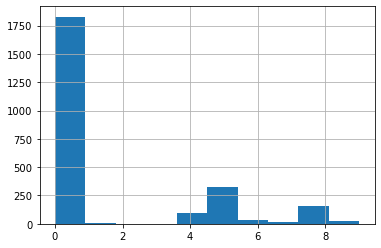

In [28]:
df_corpus['LDA_CLASE'].hist(bins = 10)

Observamos que LDA prácticamente no tuvo una buena generación de tópicos ya de que la mayoría de los documentos los clasificó en el grupo 0.

<AxesSubplot:>

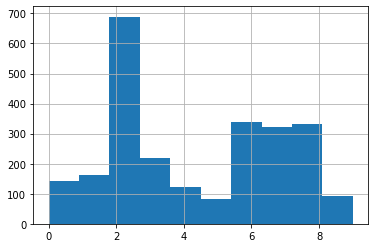

In [29]:
df_corpus['NMF_CLASE'].hist(bins = 10)

En el caso de MNF, generó una mejor agrupación, ya que la clasificación de los documentos estuvo un poco más homogenea, aunque hay muchos clasificados en la clase 2

* Opcional: Entrenar con algún modelo de acuerdo a las experiencias previas para poder después aplicar busquedas de terminos que nos traigan los documentos similares.

 ----------------------------------------------------------------------------------------------------------

* Realizar todo el proceso utilizando Gensim-Doc2Vec 

In [30]:
import multiprocessing
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

Dividimos los datos en entrenamiento y validación con un procentaje de 70% para entrenamiento y 30% para validación con shuffle, seleccionar las features X e Y

In [76]:
# tenemos que convertir TEXTO_NORM en una lista y generar una lista de todas estas listas
# para que podemos dividir los datos
X = list(df_corpus["TEXTO_NORM"].apply(lambda x: gensim.utils.simple_preprocess(x)))

In [81]:
# división entre entrenamiento y evaluación
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0, shuffle=True)

In [85]:
X_train[:1], X_test[:1]

([['ministerio',
   'trabajo',
   'empleo',
   'seguridad',
   'social',
   'secretaria',
   'trabajo',
   'resolucion',
   'numero',
   'registro',
   'numero',
   'visto',
   'expediente',
   'numero',
   'registro',
   'ministerio',
   'trabajo',
   'empleo',
   'seguridad',
   'social',
   'numero',
   'numero',
   'modificatorias',
   'resolucion',
   'secretaria',
   'trabajo',
   'numero',
   'fecha',
   'diciembre',
   'considerando',
   'fojas',
   'expediente',
   'numero',
   'obra',
   'escala',
   'salarial',
   'pactada',
   'union',
   'personal',
   'jerarquico',
   'empresas',
   'upjet',
   'federacion',
   'cooperativas',
   'republica',
   'argentina',
   'marco',
   'convenio',
   'colectivo',
   'trabajo',
   'numero',
   'conforme',
   'dispuesto',
   'negociacion',
   'colectiva',
   'numero',
   'escalas',
   'precitadas',
   'forman',
   'parte',
   'acuerdo',
   'homologado',
   'resolucion',
   'numero',
   'registrados',
   'bajo',
   'numero',
   'conforme

Para entrenar el modelo necesitamos taguear los documentos:

https://www.tutorialspoint.com/gensim/gensim_doc2vec_model.htm

In [86]:
def tagged_document(texto):
    for i, list_of_words in enumerate(texto):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])        

In [87]:
data_for_training = list(tagged_document(X_train))

Imprimimos el primer documento tagueado

In [88]:
print(data_for_training [:1])

[TaggedDocument(words=['ministerio', 'trabajo', 'empleo', 'seguridad', 'social', 'secretaria', 'trabajo', 'resolucion', 'numero', 'registro', 'numero', 'visto', 'expediente', 'numero', 'registro', 'ministerio', 'trabajo', 'empleo', 'seguridad', 'social', 'numero', 'numero', 'modificatorias', 'resolucion', 'secretaria', 'trabajo', 'numero', 'fecha', 'diciembre', 'considerando', 'fojas', 'expediente', 'numero', 'obra', 'escala', 'salarial', 'pactada', 'union', 'personal', 'jerarquico', 'empresas', 'upjet', 'federacion', 'cooperativas', 'republica', 'argentina', 'marco', 'convenio', 'colectivo', 'trabajo', 'numero', 'conforme', 'dispuesto', 'negociacion', 'colectiva', 'numero', 'escalas', 'precitadas', 'forman', 'parte', 'acuerdo', 'homologado', 'resolucion', 'numero', 'registrados', 'bajo', 'numero', 'conforme', 'surge', 'fojas', 'vuelta', 'respectivamente', 'parte', 'fojas', 'obra', 'informe', 'tecnico', 'elaborado', 'direccion', 'regulaciones', 'trabajo', 'dependiente', 'secretaria', '

Instanciamos el objeto Doc2Vec

In [89]:
model = Doc2Vec(vector_size=128, min_count=2, epochs=40)

Construimos el vocabulario

In [95]:
model.build_vocab(data_for_training)

Entrenamos el modelo

In [96]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

Analizamos la salida

In [97]:
print(model.infer_vector(['Reconociendo', 'que', 'un', 'acuerdo', 'en', 'materia', 'minera', 'será', 'de', 'utilidad']))

[ 0.04394462 -0.3955987  -0.14838472 -0.05140094 -0.22884893  0.14849281
 -0.17922258  0.274947    0.13094112 -0.26941866  0.26888105 -0.23607446
 -0.1801753   0.1976121   0.10489368 -0.45547566  0.02073151  0.55618596
 -0.09825908  0.12606527 -0.05261368  0.16880606 -0.24351762  0.1218977
  0.09953613  0.26639047 -0.02857234 -0.13449734  0.06396485 -0.26326132
  0.11366133  0.27631536  0.0804935   0.09382699  0.486612   -0.1932248
 -0.11555691  0.3579801   0.3026079  -0.13445094  0.6606501   0.46234718
 -0.07372579  0.1422692   0.13455504 -0.5131121  -0.25297463  0.1439361
  0.07294521 -0.1890048  -0.02907759  0.02216348  0.10815773 -0.2911723
 -0.0033252  -0.04146575 -0.00611809 -0.21493243  0.39837652  0.03449692
  0.47220728  0.10049681 -0.09149883  0.21708806  0.4227879   0.44076264
 -0.2711627  -0.2842149  -0.2077696  -0.03896232 -0.11511797 -0.00526219
  0.37698442  0.1808778  -0.00306953 -0.42619273  0.37444168  0.10584287
 -0.13126147 -0.06537648 -0.00979114 -0.3102684  -0.597

* Opcional: Generar un input texto y traer los tres documentos con mayor similitud semántica al texto ingresado

 ----------------------------------------------------------------------------------------------------------

## Conclusiones

 ----------------------------------------------------------------------------------------------------------

### Entrega

Formato de entrega: Deberán utilizar esta notebook con los códigos con los que hicieron el análisis y los anaálisis y conclusiones despues de cada proceso. 

Fecha de entrega: 27/9

 ----------------------------------------------------------------------------------------------------------

### Referencias

* https://www.machinelearningplus.com/nlp/gensim-tutorial/

* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado 

* https://radimrehurek.com/gensim/models/doc2vec.html